# Variational Autoencoders
***
Regular autoencoder creates discontinuos and overlapping clusters in Z space, if dims are low. Or break if sampled in space in-between the clusters.

Contrary to regular autoencoders, latent space (compressed representation) is not a simple vector, but a probability distribution.
***

__HOW__: 

Lets 'gather' state vectors and replace them with state cluster in Z, which can be generated by continuously sampling probability distribution function $P(Z|X = input)$

Which reads: _what is the prob. distr Z for a given input data X._

Ideally, each cluster will represent to some specific feature and not overlap with other clusters.

Parameters of a distribution are trained, and are dependant on input data. 

Decoder, when given latent vector, will __\*kind of\*__ try to detect which distribution, thus feature, that point in z-space is related to.

***
Due to vastness of Z-space we would like to constraint our prob. dist. functions to simpler ones, like Gaussian/Normal distribution $P \sim N(\mu,\Sigma)$.


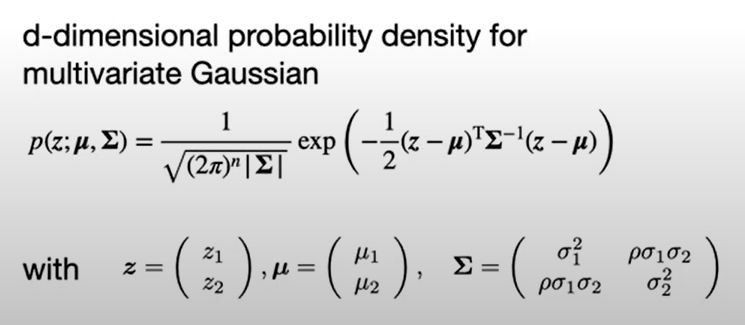

K-L divergence is a metric that shows likeness or 'distance' between two distributions, even if they are different distribution types.

It is a __First part of a loss function__ and can be derived for Normal distribution.

__Second part of a loss function__ is, similarly to regular autoencoder, pixel-wise error.

good sources: 

* KL-divergence metric: https://youtu.be/9_eZHt2qJs4?list=LL
* Evidence Lower BOund (ELBO) loss function derivation: https://youtu.be/HxQ94L8n0vU
* ELBO. math worse, simple example: https://youtu.be/iwEzwTTalbg?t=726 generally good
* base code for VAE: https://www.youtube.com/watch?v=afNuE5z2CQ8


In [1]:
import torch, matplotlib.pyplot as plt, numpy as np
from torchvision import (datasets, transforms)
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from torchinfo import summary
import torchvision.utils as vutils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

In [17]:
import os
# set working dir to repo directory
head, tail = os.path.split(os.getcwd())
while tail != 'aj_python_tool_lib':
    head, tail = os.path.split(head)
os.chdir(os.path.join(head, tail))
#os.getcwd()
from neural_networks.nn_helper_functions import (conv2D_dims,conv2DT_dims)
from IPython.display import clear_output
clear_output(wait=True)

In [18]:
BATCH_SIZE = 256
data_path   = os.path.join('neural_networks', 'data')
mnist_data  = datasets.MNIST(root=data_path, train = False, transform = transforms.ToTensor())
data_loader = DataLoader(mnist_data, batch_size=BATCH_SIZE, shuffle=True)

img_shape = torch.tensor(mnist_data[0][0].shape)
img_n_pix = mnist_data[0][0].numel()
print(img_shape,img_n_pix)
#next(iter(data_loader))

tensor([ 1, 28, 28]) 784


In [26]:
conv_layer_params = torch.tensor([ #[ks     , st    , pd    , pd_out    ,dil]
                                    [3      , 2     , 1     , -1        , -1],
                                    [3      , 2     , 1     , -1        , -1],
                                    [3      , 2     , 1     , -1        , -1],
                                    [3      , 2     , 0     , -1        , -1]
                                    ])
param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']

conv_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_layer_params]


ouput_dims_forw = []                      
in_dims = img_shape[-2:]
print('Layer in-out dimensions:')
for i,dic in enumerate(conv_layer_params_d):
    out_dims = conv2D_dims(in_dims,**dic)
    print(f'layer {i+1:<2}:', in_dims, ' -> ', out_dims)
    in_dims = out_dims
    ouput_dims_forw.append(out_dims)
ouput_dims_forw

Layer in-out dimensions:
layer 1 : tensor([28, 28])  ->  tensor([14, 14])
layer 2 : tensor([14, 14])  ->  tensor([7, 7])
layer 3 : tensor([7, 7])  ->  tensor([4, 4])
layer 4 : tensor([4, 4])  ->  tensor([1, 1])


[tensor([14, 14]), tensor([7, 7]), tensor([4, 4]), tensor([1, 1])]

In [6]:
conv_T_layer_params = torch.tensor([   #[ks     , st    , pd    , pd_out   , dil]
                                        [3      , 2     , 0     , 1       , -1 ],
                                        [3      , 2     , 1     , 0       , -1 ],
                                        [3      , 2     , 1     , 1        , -1 ],
                                        [3      , 2     , 1     , 1        , -1 ]
                                    ])

param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']
conv_T_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_T_layer_params]
                            
in_dims = ouput_dims_forw[-1]
print('Layer in-out dimensions:')
for i,dic in enumerate(conv_T_layer_params_d):
    out_dims = conv2DT_dims(in_dims,**dic)
    print(f'layer {i+1:<2}:', in_dims, ' -> ', out_dims)#layer {i+1}; {dic}\n
    in_dims = out_dims

Layer in-out dimensions:
layer 1 : tensor([1, 1])  ->  tensor([4, 4])
layer 2 : tensor([4, 4])  ->  tensor([7, 7])
layer 3 : tensor([7, 7])  ->  tensor([14, 14])
layer 4 : tensor([14, 14])  ->  tensor([28, 28])


In [7]:
ch = [1, 16, 32, 64, 128]
chans_forw = [{'in_channels':inp, 'out_channels':out} for inp,out in list(zip(ch[:-1],ch[1:]))]
display(chans_forw)
ch_r = list(reversed(ch))
chans_rev = [{'in_channels':inp, 'out_channels':out} for inp,out in list(zip(ch_r[:-1],ch_r[1:]))]
display(chans_rev)
latent_space_dims = 2

[{'in_channels': 1, 'out_channels': 16},
 {'in_channels': 16, 'out_channels': 32},
 {'in_channels': 32, 'out_channels': 64},
 {'in_channels': 64, 'out_channels': 128}]

[{'in_channels': 128, 'out_channels': 64},
 {'in_channels': 64, 'out_channels': 32},
 {'in_channels': 32, 'out_channels': 16},
 {'in_channels': 16, 'out_channels': 1}]

In [20]:
z_dims = ch[-1]*torch.prod(ouput_dims_forw[-1])
print(z_dims)

reshape_dims = torch.tensor([-1, ch[-1], *ouput_dims_forw[-1]])
reshape_dims

tensor(128)


tensor([ -1, 128,   1,   1])

In [116]:
activation = nn.LeakyReLU(0.01)#nn.ReLU()


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
        
class VAE_CONV(nn.Module):
    def __init__(self):

        super(VAE_CONV, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(**chans_forw[0], **conv_layer_params_d[0]),
            activation,
            nn.Conv2d(**chans_forw[1], **conv_layer_params_d[1]),
            activation,
            nn.Conv2d(**chans_forw[2], **conv_layer_params_d[2]),
            activation,
            nn.Conv2d(**chans_forw[3], **conv_layer_params_d[3]),
            nn.Flatten()
        )

        self.z_mean     = torch.nn.Linear(z_dims, latent_space_dims)
        self.z_log_var  = torch.nn.Linear(z_dims, latent_space_dims)

        self.decoder = nn.Sequential(
            torch.nn.Linear(latent_space_dims, z_dims),
            Reshape(*reshape_dims),
            nn.ConvTranspose2d(**chans_rev[0], **conv_T_layer_params_d[0]),
            activation,
            nn.ConvTranspose2d(**chans_rev[1], **conv_T_layer_params_d[1]),
            activation,
            nn.ConvTranspose2d(**chans_rev[2], **conv_T_layer_params_d[2]),
            activation,
            nn.ConvTranspose2d(**chans_rev[3], **conv_T_layer_params_d[3]),
            nn.Sigmoid()
        )
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(*z_mu.shape, device=device)
        z = z_mu + eps * torch.exp(z_log_var/2) 
        return z

    def forward(self,img):
        pre_z = self.encoder(img)
        z_mean      = self.z_mean(pre_z) 
        z_log_var   = self.z_log_var(pre_z)
        z = self.reparameterize(z_mean, z_log_var)
        #print(z[0])
        decoded = self.decoder(z)
        return z, z_mean, z_log_var, decoded
    
    def decode(self,z):
        return self.decoder(z)
    
model = VAE_CONV().to(device)

#summary(model, input_size=tuple(img_shape))

In [117]:
num_epochs = 15
alpha = 1.0
LEARNING_RATE = 0.0005
output = {i:[] for i in range(10)}
OG = None
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = LEARNING_RATE)#, weight_decay=1e-5
criterion = F.mse_loss
for i in range(num_epochs):
    model.train()
    for batch_idx, (features, labels) in enumerate(data_loader):
        features = features.to(device)

        encoded, z_mean, z_log_var, decoded = model(features)
        
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                    - z_mean**2 
                                    - torch.exp(z_log_var), 
                                    axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension

        # pixelwise = criterion(decoded, features)#, reduction='none')
        # pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        # pixelwise = pixelwise.mean() # average over batch dimension
        #pixelwise_loss = criterion(decoded, features)
        pixelwise_loss = F.mse_loss(decoded,features,reduction='none').view(batchsize,-1).sum(1).mean()
        loss = alpha*pixelwise_loss + kl_div
        
        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()
        
        if i == num_epochs - 1:
            for f,k in zip(encoded, labels):
                output[int(k)].append(f.detach().to('cpu'))
        #grid = vutils.make_grid(reconstruct_img_b,nrow=4, normalize=True, pad_value=1)
    #output.append(np.transpose(grid,(1,2,0)))
    OG = np.transpose(vutils.make_grid(decoded[:4*4,...],nrow=4, normalize=True, pad_value=1).detach().to("cpu"),(1,2,0))
    print('[%d\t/%d]Loss: %.4f'% (i, num_epochs, loss))#, end='\r')
    

[0	/15]Loss: 132.6961
[1	/15]Loss: 117.8203
[2	/15]Loss: 84.7260
[3	/15]Loss: 55.7178
[4	/15]Loss: 48.7307
[5	/15]Loss: 49.8167
[6	/15]Loss: 43.6445
[7	/15]Loss: 40.7975
[8	/15]Loss: 50.2528
[9	/15]Loss: 43.3338
[10	/15]Loss: 44.4090
[11	/15]Loss: 41.3684
[12	/15]Loss: 43.1273
[13	/15]Loss: 45.4117
[14	/15]Loss: 46.5278


In [112]:
output2 = [np.array(a) for a in output.values()]

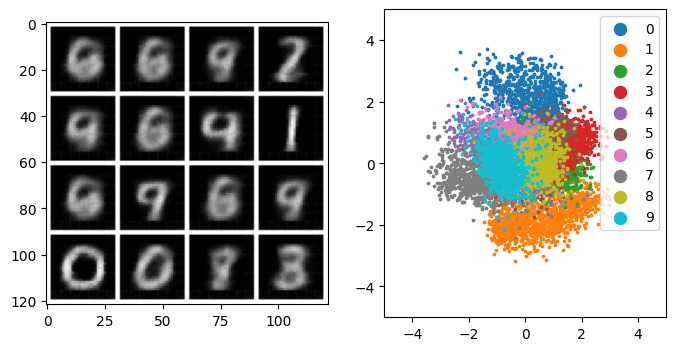

In [113]:
plt.rcParams["legend.markerscale"] = 5
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].imshow(OG)
for i,pts in enumerate(output2):
    ax[1].scatter(*pts.T, label = str(i),s = 3)
h2 = ax[1]
h1 = ax[0]
ax[1].set_ylim(-5,5)
ax[1].set_xlim(-5,5)
ax[1].legend()


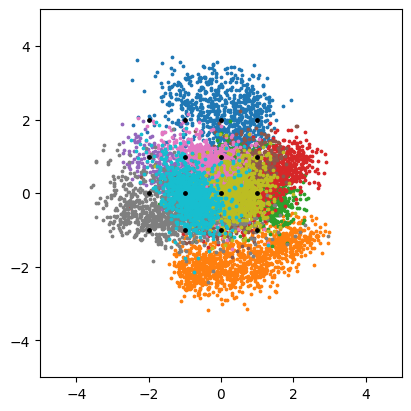

In [138]:
x_range = torch.arange(-2.0, 2.0, 1)  # 2.5 to include the endpoint
y_range = torch.arange(-1.0, 3.0, 1)

# Create a grid of points using meshgrid
x_grid, y_grid = torch.meshgrid(x_range, y_range)
points = torch.stack((x_grid.flatten(), y_grid.flatten()), dim=1)

fig, ax = plt.subplots(1,1, sharex=1, sharey=1, figsize=(4, 4), layout='constrained')
for i,pts in enumerate(output2):
    ax.scatter(*pts.T, label = str(i),s = 3)
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
for pt in points:
    ax.scatter(*pt, s = 6, c= 'k')

C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_13736\4245016613.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = model.decode(torch.tensor(points[i], device='cuda:0'))[0,0].detach().to('cpu').numpy()


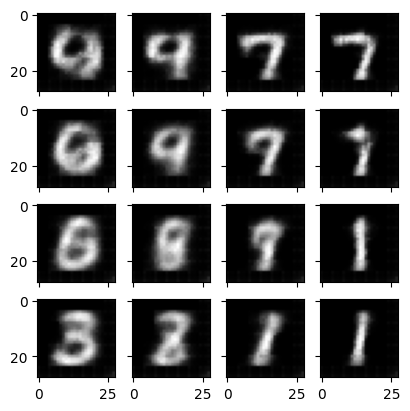

In [139]:
fig, ax = plt.subplots(4,4, sharex=1, sharey=1, figsize=(4, 4), layout='constrained')
ax = ax.flatten()
for i in range(len(points)):
    img = model.decode(torch.tensor(points[i], device='cuda:0'))[0,0].detach().to('cpu').numpy()
    ax[i].imshow(img, 'gray')
